### Demo for Machine Learning and Pattern Recognition guest lecture, University of Edinburgh, 18.11.2016.

#### John Quinn

Given observations of crop disease, which could come from an image classification app running on a phone, we can construct spatial models of disease spread.

In [1]:
import GPy
import shapefile
import sys
sys.path.append('geospatial')
import ugplot
%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


Helper function to plot inferences on a map

In [2]:
def plot_heatmap(h,cmap=plt.cm.plasma):
    h = h.reshape((resolution, resolution))
    ax = plt.gca()
    im = ax.imshow(np.flipud(h),cmap=cmap,
                           extent=[xlim_l, xlim_u, ylim_l, ylim_u],
                            interpolation=None)
    cbar = plt.colorbar(im, shrink=.5) 
    ugplot.plot_country_outline()
    ugplot.prettify_map()
    plt.gcf().set_size_inches(10,10)

Construct a grid of coordinates $f_{*} \in \mathbb{R}^2$ covering the extent of Uganda

In [3]:
sf = shapefile.Reader("geospatial/shapefiles/UGA_country")
shapes = sf.shapes()
coords = np.array(shapes[0].points)
X_UGA = coords[:,0]
Y_UGA = coords[:,1] 
xlim_l = min(X_UGA) - .1
xlim_u = max(X_UGA) + .1
ylim_l = min(Y_UGA) - .1
ylim_u = max(Y_UGA) + .1
resolution = 100 
x1, x2 = np.meshgrid(np.linspace(xlim_l, xlim_u, resolution),
                     np.linspace(ylim_l, ylim_u, resolution))
f_star = np.vstack([x1.reshape(x1.size), x2.reshape(x2.size)]).T

Some observations to model: a list of longitudes/latitudes ($X$) and a list of disease labels ($Y$)

In [4]:
# Survey locations
X = np.array([[31.1,1.2],
              [33.,2.]])

# Disease label (1=infected, 0=healthy)
Y = np.array([[1],
              [1]])

We can model crop disease observation data by assuming the level of disease incidence $y^{(i)}$ at a location $\mathbf{x}^{(i)}$ is strongly related to the level of disease incidence $y^{(j)}$ at location $\mathbf{x}^{(j)}$ if these locations are close together. The further away the locations are, the less they affect each other.

This could be specified with a kernel:

$k(\mathbf{x}^{(i)}, \mathbf{x}^{(j)}) \;=\; \exp\!\bigg(-{\textstyle\frac{1}{2}}
    \sum_{d=1}^D (x_d^{(i)} - x_d^{(j)})^2 / \ell^2
    \bigg)$
    
where here $D=2$, and we can set $\ell$ with knowledge about the infection mechanism of the disease. This gives us a Gaussian process.

In [12]:
kernel = GPy.kern.RBF(2,lengthscale=.3)
m = GPy.models.GPRegression(X,Y,kernel) 

We can make predictions across the whole map (locations $X_*$) given the observations $Y$ at locations $X$:

In [13]:
f_star_mean, f_star_cov = m.predict(f_star)

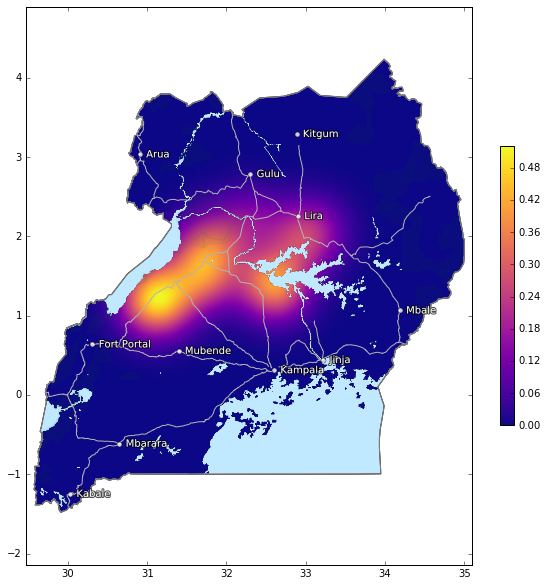

In [14]:
plot_heatmap(f_star_mean)

- As it's a map, it helps to plot the geographical context
- Different length scales $\ell$ give us different maps
- We can see the covariance of the predictions as well as the mean
- Labels don't have to be 0 or 1; they could represent the proportion of infected plants at a location.

In [8]:
# Survey locations
X = np.array([[31.1,1.2],
              [33.0,2.0],
              [31.8,1.9],
              [32.6,1.4],
              [31.4,1.6],
              [31.7,1.5],
              [32.3,2.2],
              [33.2,2.2]])

# Disease label (1=infected, 0=healthy)
Y = np.array([[1.0],
              [0.5],
              [0.6],
              [0.8],
              [0.4],
              [0.7],
              [0.3],
              [0.2]])